# Met Data Processing
Final/Clean Version of MET_Data_Analysis_Raw.ipynb
by Bharat Sharma <br>
sharmabd@ornl.gov <br>
Site: US-DUKE



In [1]:
# importing libraries
import xarray as xr
import glob
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Files
- **ELM-DUKE** : has the nc files that we use to run the current version of ELM-FATES <br>
- **[FACEMDS_Walker2018](https://data.ess-dive.lbl.gov/view/ess-dive-7807cf86f1dd42a-20181127T173047368940)** : Processed Data (My focus: DUKE) <br>
- **[DukeFACE_Oren2022](https://data.ess-dive.lbl.gov/view/doi:10.15485/1895465)**: Updated DUKE met Data


In [42]:
# paths

paths = {}
paths ["ELM-DUKE"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/ELM_Data/data/atm/datm7/CLM1PT_data/1x1pt_US-DUK/"
paths ["FACEMDS_Walker2018"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/Walker_2018_FATES_MDS/data/"
paths ["DukeFACE_Oren2022"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/Oren_2022_DUKE_Met/data/"
paths ["Save_Processed"] = "/Users/ud4/Documents/FACEMDS/MET_Data_Processing/Oren_2022_Met_Data_processed/"

## ELM Duke Data

In [3]:
key = "ELM-DUKE"
ds_elm_all= xr.open_mfdataset(glob.glob(f"{paths[key]}*.nc"))

In [4]:
#cftime to datetime 

def cftime_to_dtime (cftime_object):
    # Convert cftime.DatetimeNoLeap to datetime
    datetime_object = datetime(
        year=cftime_object.year,
        month=cftime_object.month,
        day=cftime_object.day,
        hour=cftime_object.hour,
        minute=cftime_object.minute,
        second=cftime_object.second,
        microsecond=cftime_object.microsecond,
    )
    return datetime_object

time_objects = [cftime_to_dtime (t) for t in ds_elm_all.time.values]
print (time_objects)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



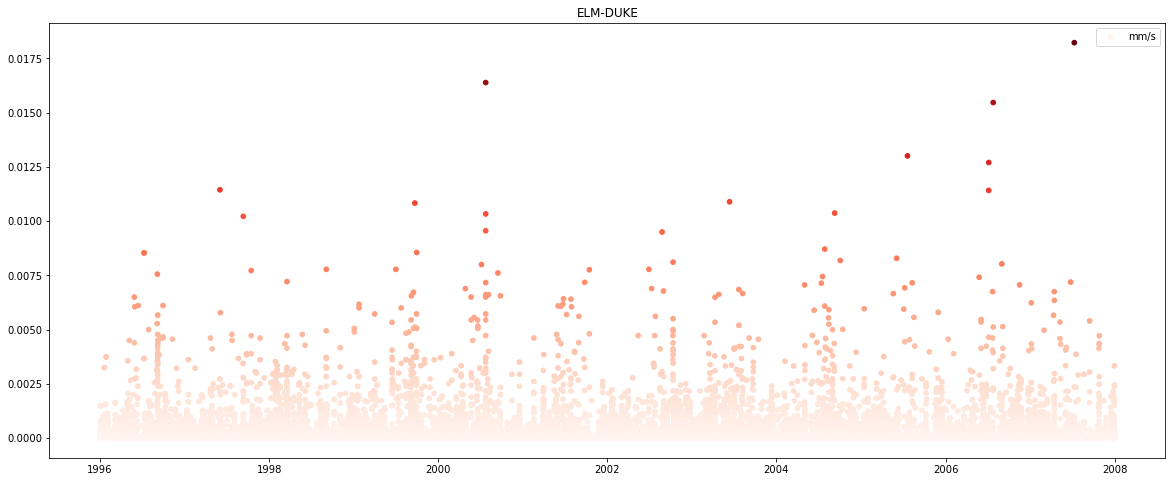

In [5]:
fig1 = plt.figure(figsize=(20,8))
plt.scatter(x= time_objects, y=ds_elm_all.PRECTmms, 
            c=ds_elm_all.PRECTmms, cmap='Reds', 
            s=22, marker = 'o',label = ds_elm_all.PRECTmms.units,
           )
plt.title(f"{key}")
plt.legend()

## Investigating FACEMDS_Walker2018

In [6]:
key = "FACEMDS_Walker2018"
ds_Walker_h= xr.open_dataset(f"{paths[key]}DUKE_forcing_h.nc", decode_times=False)

from datetime import datetime, timedelta

def seconds_to_datetime(seconds, reference_date):
    return reference_date + timedelta(seconds=seconds)

reference_date= datetime(1996, 1, 1, 0 , 0)

list_seconds = ds_Walker_h.TIME[...].values
list_seconds= np.asarray(list_seconds, dtype = float)
resulting_datetime = [seconds_to_datetime(seconds,reference_date) for seconds in list_seconds]


/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


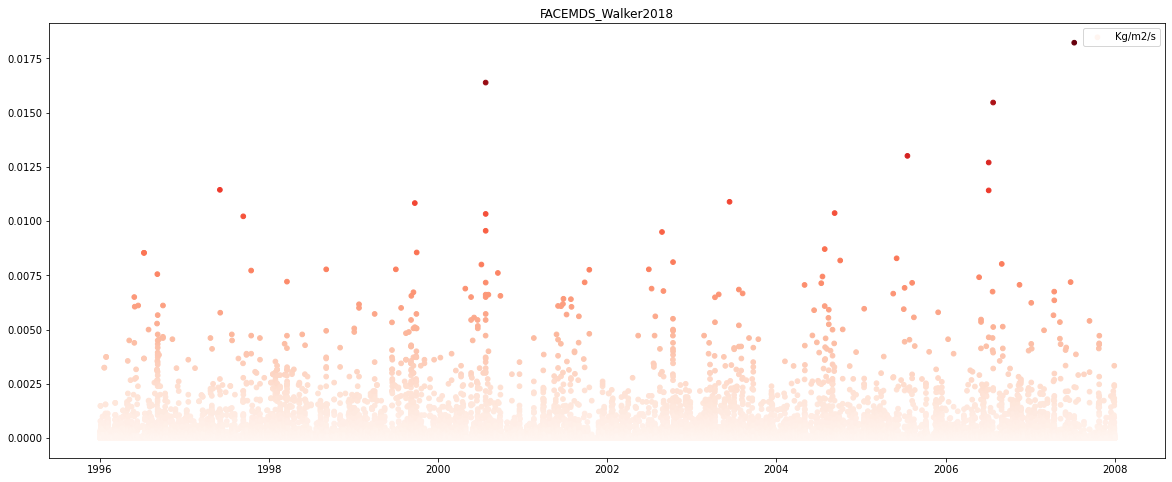

In [7]:
fig2 = plt.figure(figsize=(20,8))
plt.scatter(x= resulting_datetime, y=ds_Walker_h['Rainf'], 
            c=ds_Walker_h['Rainf'], cmap='Reds', 
            s=22, marker = 'o',label = ds_Walker_h['Rainf'].units
           )
plt.title(f"{key}")
plt.legend()

### FACEMDS_Walker CSV files

In [8]:
key = "FACEMDS_Walker2018"

#### Reading Hourly files

In [9]:
df_FACEMDS = {}
df_FACEMDS ['h'] = pd.read_csv(glob.glob(f"{paths[key]}DUKE*_h.txt")[0], delimiter= '\t')
print(len(df_FACEMDS ['h'] .columns))
df_FACEMDS ['h'] .columns

30


/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['YEAR', 'DTIME', 'DOY', 'HRMIN', 'Rainf', 'Rainf_f ', 'Tair', 'Tair_f',
       'RH', 'RH_f', 'VPD', 'VPD_f', 'Qair', 'Qair_f', 'Wind', 'Wind_f',
       'SWdown', 'SWdown_f', 'PAR', 'PAR_f', 'LWdown', 'LWdown_f', 'PSurf',
       'PSurf_f', 'aCO2', 'eCO2', 'aO3', 'eO3', 'Ndep', 'SolarElevation'],
      dtype='object')

## Oren New Met Data

In [47]:
# Dictionary that will contain the dataframes of all the variables from Oren New Met Data
dict_dfs_common = {}

In [48]:
# Specify the file path
DuplicateDataFilename = 'DuplicateDukeData.txt'

# This file path is to document the duplicate Data in Duke Data

### AT : Tair
Oren Data has 3 dirs for AT for different plots, time periods, and sensors. <br>
I intend to use `*_gl.csv` files; i believe these are gap filled. <br>
I will save the mean of the plots for FACEMDS <br>
The common sensor data will be used among all the files.

In [49]:
key = "DukeFACE_Oren2022"
var_key = "AT"
face_var_key = "Tair"

plots_cols = ['R1uat', 'R2uat', 'R3uat', 'R4uat','R5uat', 'R6uat', 'R7uat', 'R8uat']

In [50]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Define a custom sorting key function to extract the year from the file path
def extract_year(filepath):
    return int(filepath.split(f'{var_key}')[-1][:4]) # Year

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)


In [14]:
# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf




In [51]:
file = sorted_filepaths[0]
df_tmp = pd.read_csv(file)

In [52]:
df_tmp

,Year,JDT,DOY,Time,R1uat,R2uat,R3uat,R4uat,R5uat,R6uat,R7uat,R8uat
0,1997,2682.71,125,1730,21.5,21.5,21.5,21.5,21.5,21.4,21.5,21.6
1,1997,2682.73,125,1800,20.4,20.4,20.4,20.4,20.4,20.4,20.4,20.5
2,1997,2682.75,125,1830,18.9,18.9,18.9,18.9,18.9,18.8,18.9,18.9
3,1997,2682.77,125,1900,17.9,17.9,17.9,17.9,17.9,18.1,17.6,18.1
4,1997,2682.79,125,1930,16.6,16.6,16.6,16.6,16.6,16.5,16.9,16.5
...,...,...,...,...,...,...,...,...,...,...,...,...
11529,1997,2922.90,365,2200,-2.0,-0.7,-1.6,-2.0,-1.9,-2.2,-2.1,-1.8
11530,1997,2922.92,365,2230,-2.3,-0.9,-1.9,-2.3,-2.1,-2.5,-2.4,-2.1
11531,1997,2922.94,365,2300,-2.4,-1.1,-2.1,-2.4,-2.3,-2.6,-2.5,-2.2
11532,1997,2922.96,365,2330,-2.6,-1.2,-2.2,-2.6,-2.4,-2.7,-2.6,-2.3


### Precip : Rainf
units: mm

In [44]:
key = "DukeFACE_Oren2022"
var_key = "Precip"
face_var_key = "Rainf"

plots_cols = ['FACE.PO']

In [16]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### RH : RH
Relative Humidity

In [17]:
key = "DukeFACE_Oren2022"
var_key = "RH"
face_var_key = "RH"
plots_cols = ['R1urh', 'R2urh', 'R3urh', 'R4urh','R5urh', 'R6urh', 'R7urh', 'R8urh']

In [18]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### SM:SM 
(not in existing WalkerFACEMDS Data)<br>
Soil moisture integrates measurements from 0 to 30cm depth 

In [19]:
key = "DukeFACE_Oren2022"
var_key = "SM"
face_var_key = "SM"

plots_cols = ['R1tdr', 'R2tdr', 'R3tdr', 'R4tdr','R5tdr', 'R6tdr', 'R7tdr', 'R8tdr']

In [20]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### SWP: SWP 
not in existing Walker 2018 <br>
(Soil water potential) <br>
from 2007 to 2012

In [21]:
key = "DukeFACE_Oren2022"
var_key = "SWP"
face_var_key = "SWP"
plots_cols = ['R1swp', 'R2swp', 'R3swp', 'R4swp','R5swp', 'R6swp']

In [22]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### SVP: SVP

Saturated Vapor Pressure; Not in Walker 2018<br>
units kPa   

In [23]:
key = "DukeFACE_Oren2022"
var_key = "SVP"
face_var_key = "SVP"
plots_cols = ['R1usvp', 'R2usvp', 'R3usvp', 'R4usvp','R5usvp', 'R6usvp', 'R7usvp', 'R8usvp']

In [24]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### VPD: VPD
Vapor pressure deficit <br>
Units kPa <br>

In [25]:
key = "DukeFACE_Oren2022"
var_key = "VPD"
face_var_key = "VPD"
plots_cols = ['R1uvpd', 'R2uvpd', 'R3uvpd', 'R4uvpd','R5uvpd', 'R6uvpd', 'R7uvpd', 'R8uvpd']

In [26]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf





### SLT: SLT

Walker 2018 does not have this data <br>
soil temperature from plots 1-6, one sensor per plot at 15 cm depth, measured in Degree Celsius. <br>
I will be averaging over plots 2-6 because 1 was upgraded over time and 15 cm depth was not avaiable later 

In [27]:
key = "DukeFACE_Oren2022"
var_key = "SLT"
face_var_key = "SLT"
plots_cols = ['R2slt', 'R3slt', 'R4slt','R5slt', 'R6slt']

In [28]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{var_key}*/*_gf.csv"))

# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf


### PAR: PAR

The data from 2008-12 was averaged to get PAN and Rn <br>
PAR - Photosynthetically active radiation, umol/m^2\*s <br>
PAR had values from only one plot for 1997-2007 and from two plots for 2008-2012, which were averaged <br> 

In [29]:
key = "DukeFACE_Oren2022"
var_key = "PAR"
face_var_key = "PAR"
plots_cols = ['PAR']

exp_filename = "Rad" # Exception in the filename

In [30]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{exp_filename}*/*_gf.csv"))

# Define a custom sorting key function to extract the year from the file path
def extract_year(filepath):
    return int(filepath.split(f'{exp_filename}')[-1][:4]) # Year
    
# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf


### Rn: Rn 

Not in Walker 2018 <br>
The data from 2008-12 was averaged to get PAN and Rn <br>
Rn  - Net radiation. Q7 sensor before 2004, CNR1 thereafter, W/m^2  <br>
Rn had values from only one plot for 1997-2007 and from two plots for 2008-2012, which were averaged <br> 

In [31]:
key = "DukeFACE_Oren2022"
var_key = "Rn"
face_var_key = "Rn"
plots_cols = ['Rn']

exp_filename = "Rad" # Exception in the filename

In [32]:
# gap filled files
files = sorted(glob.glob(f"{paths[key]}DukeFACE_{exp_filename}*/*_gf.csv"))

# Define a custom sorting key function to extract the year from the file path
def extract_year(filepath):
    return int(filepath.split(f'{exp_filename}')[-1][:4]) # Year
    
# Sort the list of file paths based on the Year
sorted_filepaths = sorted(files, key=extract_year)

# Create a common dataframe
# List of column names
common_columns = ['Year', 'JDT', 'DOY', 'Time', f'{face_var_key}']

# Create an empty DataFrame with the specified columns
df_tmp_common_gf = pd.DataFrame(columns=common_columns)


selected_columns = plots_cols
# Open the file in append mode and write text
with open(DuplicateDataFilename, 'a') as duplicate_data:
    for file in sorted_filepaths:
        i_dup_file_name = 0 # to save file name once for multiple dupliate entries
        df_tmp = pd.read_csv(file)
        for lbl,gr in df_tmp.groupby(['Year','DOY','Time']):
            if len(gr) > 1:
                if i_dup_file_name == 0:
                    duplicate_data.write(f"{'/'.join(file.split('/')[-3:])}\n")
                duplicate_data.write(f"{gr.iloc[:,:4]}\n")
                i_dup_file_name+=1
                
        # Calculate the mean of selected columns
        df_tmp[f"{face_var_key}"] = round(df_tmp[selected_columns].mean(axis=1),2)
        # only saving the common columns
        df_tmp = df_tmp[common_columns]
        #Appending all the common columns to the common dataframe
        df_tmp_common_gf = df_tmp_common_gf.append(df_tmp)
    duplicate_data.write(f"\n")
dict_dfs_common[f"{face_var_key}"] = df_tmp_common_gf


In [34]:
dict_dfs_common.keys()

dict_keys(['Tair', 'Rainf', 'RH', 'SM', 'SWP', 'SVP', 'VPD', 'SLT', 'PAR', 'Rn'])

### Making a common Dataframe of 30 min data

Largest timeseries is from "PAR" <br>
1997 - 2558.00 - 1 - 30 to 2012 - 8401.98 - 366 - 2400 <br>
Using these Index to fill in the rest <br>
FillValue = -6999.0

In [35]:
# list of variables 
keys_vars = list(dict_dfs_common.keys())

# Making a copy of the dataframe with most data
df_all_vars_30m =  dict_dfs_common['PAR'].copy(deep=True)

# Dropping JDT column since it is not same across vars based on Dates and time, due to which I get NaNs during merge
df_all_vars_30m = df_all_vars_30m.drop('JDT',axis=1)

for k in keys_vars:
    df_all_vars_30m = pd.merge(df_all_vars_30m, dict_dfs_common[k].drop('JDT',axis=1), how = 'left')
    
    
fill_value = -6999.    
df_all_vars_30m['Rn'] = df_all_vars_30m['Rn'].replace(fill_value, np.nan)

# Fill NaNs with -6999.0
df_all_vars_30m_FV = df_all_vars_30m.fillna(fill_value)

# Adding a datetime column 
# Convert DOY and Time to timedelta

# Convert 'Time' values to HH:MM format
time_str = df_all_vars_30m['Time'].astype(str)
time_str = time_str.str.zfill(4)  # Ensure all times are 4 digits

# Making Sure time_str in has integer values only
#time_int = time_str.astype(float).astype(int)
time_int = np.asarray(np.asarray(time_str, dtype=float), dtype =int)

# Extract hours and minutes
hours = np.asarray(time_int//100, dtype = int)
minutes = np.asarray(time_int%100, dtype = int)

# Calculate the total minutes
total_minutes = hours * 60 + minutes

df_all_vars_30m['Date'] = pd.to_timedelta(df_all_vars_30m['DOY'] - 1, unit='D') + pd.to_timedelta(total_minutes, unit='m')

# Add Year to the Date
df_all_vars_30m['Date'] = pd.to_datetime(df_all_vars_30m['Year'].astype(float).astype(int).astype(str)) + df_all_vars_30m['Date']
df_all_vars_30m_FV['Date'] = df_all_vars_30m['Date']



In [38]:
df_all_vars_30m_FV.head()

,Year,DOY,Time,PAR,Tair,Rainf,RH,SM,SWP,SVP,VPD,SLT,Rn,Date
0,1997.0,1.0,30.0,0.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,1997-01-01 00:30:00
1,1997.0,1.0,100.0,0.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,1997-01-01 01:00:00
2,1997.0,1.0,130.0,0.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,1997-01-01 01:30:00
3,1997.0,1.0,200.0,0.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,1997-01-01 02:00:00
4,1997.0,1.0,230.0,0.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,-6999.0,1997-01-01 02:30:00


In [40]:

# Saving the processed Data

df_all_vars_30m_FV.to_csv(f"{paths['Save_Processed']}Processed_Duke_Met_Data_All_Vars_30m_FV.csv")
df_all_vars_30m.to_csv(f"{paths['Save_Processed']}Processed_Duke_Met_Data_All_Vars_30m.csv")

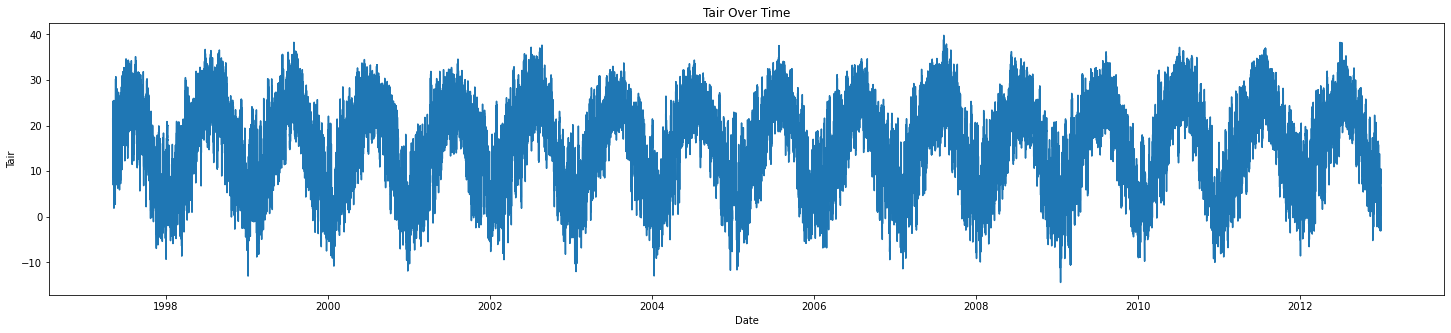

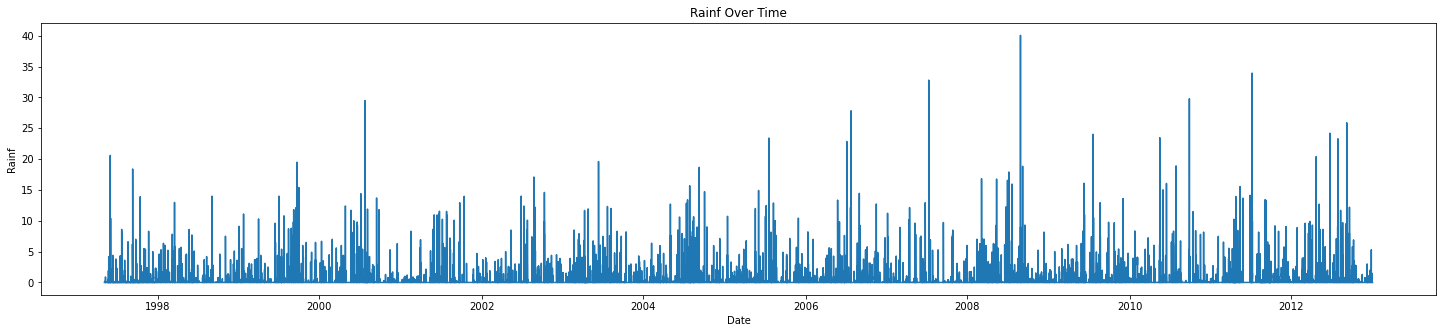

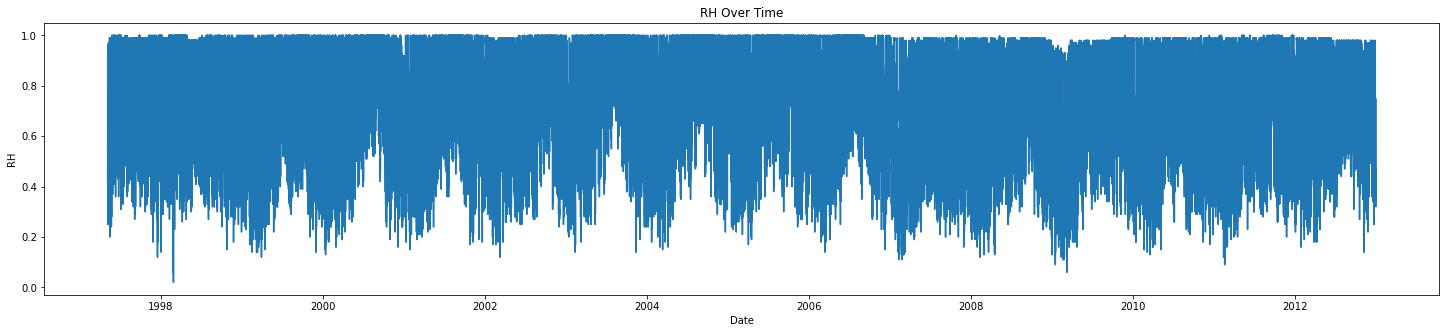

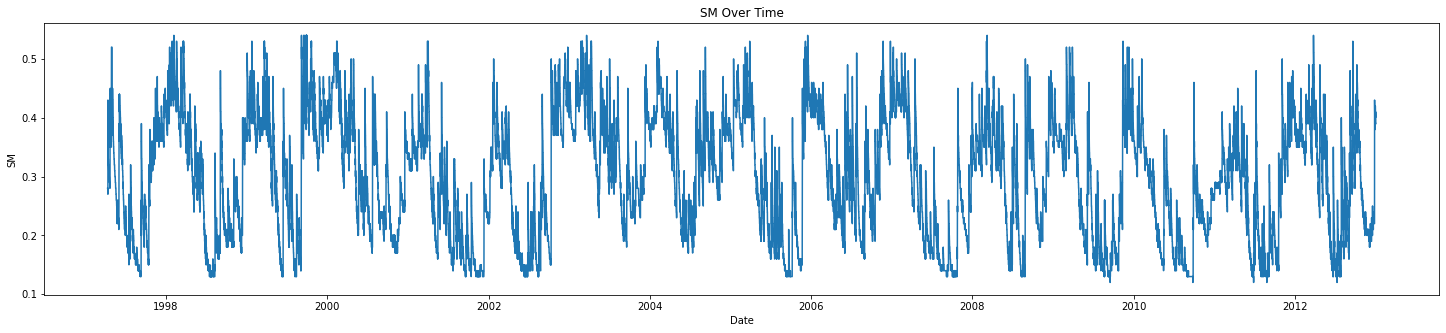

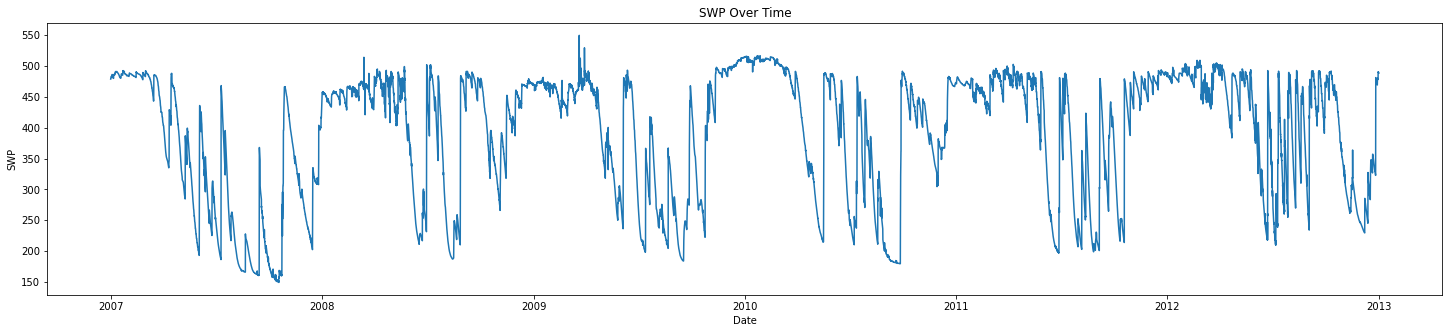

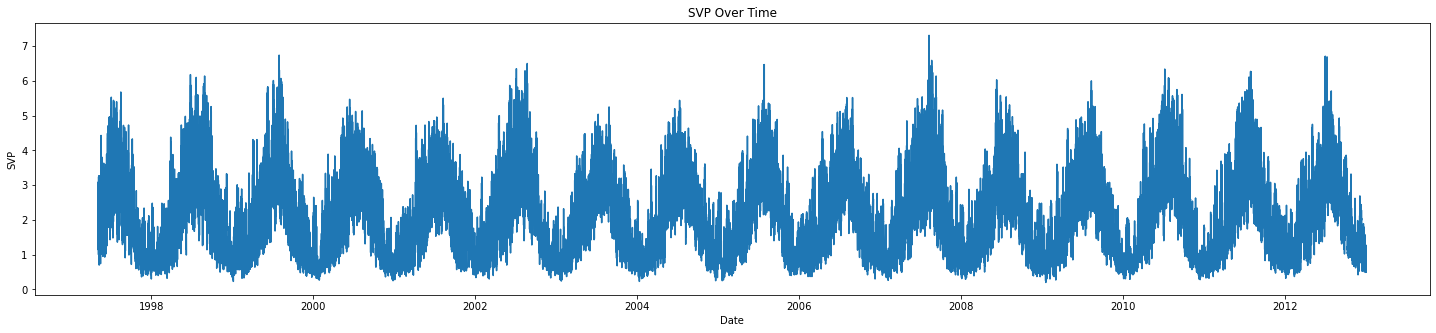

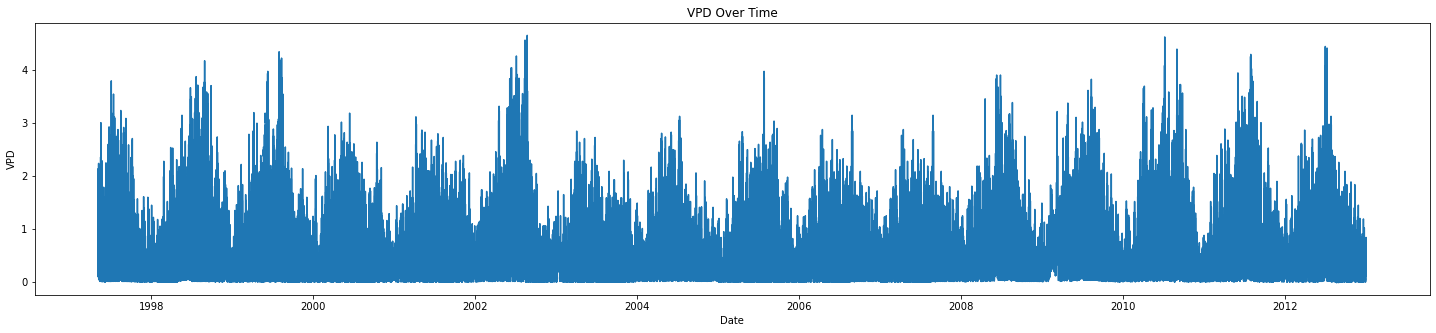

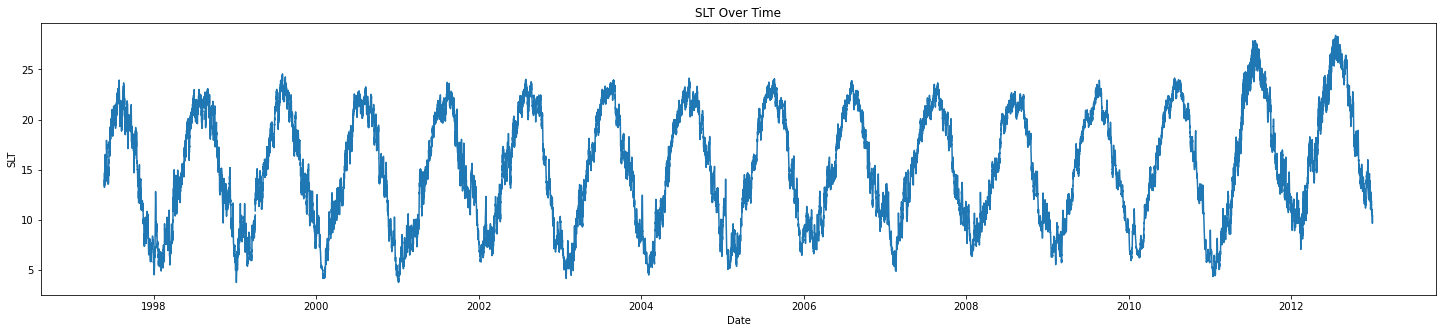

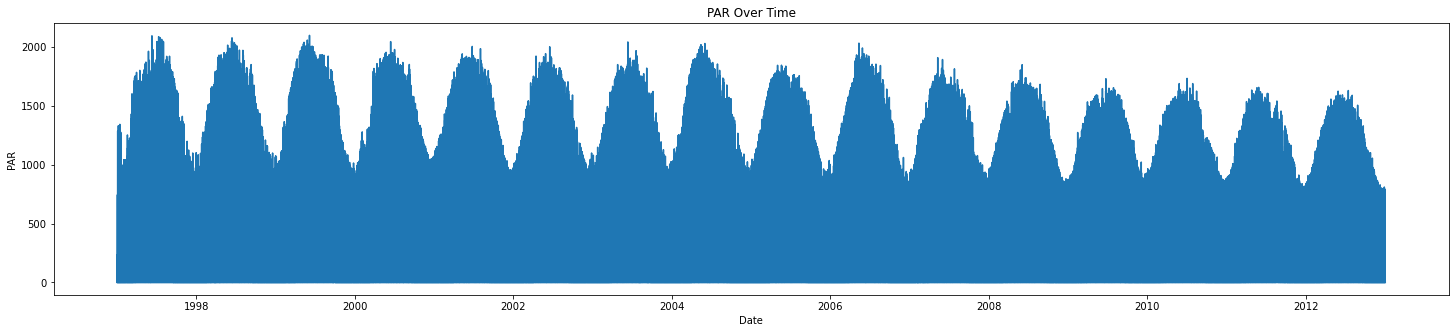

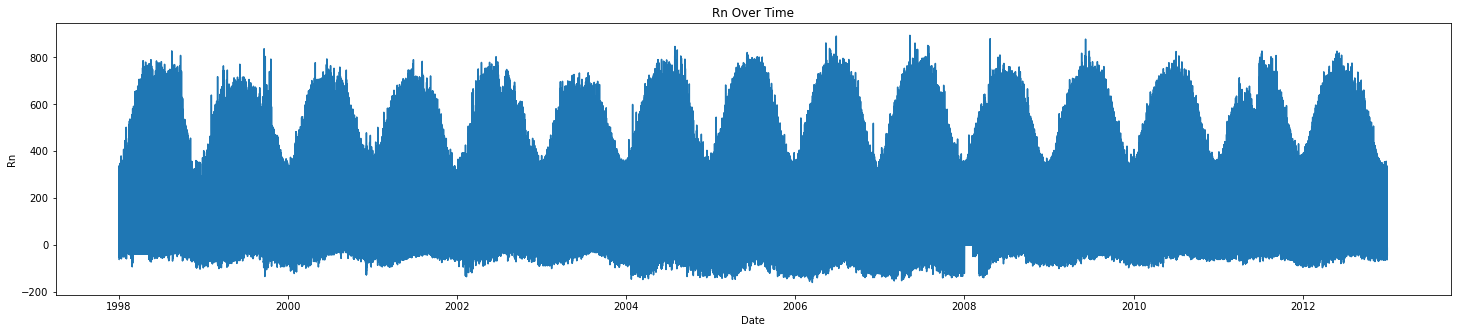

In [37]:
for k in keys_vars:
     # Set the figure size
    plt.figure(figsize=(25, 5))

    # Create the line plot
    plt.plot(df_all_vars_30m['Date'], df_all_vars_30m[k])

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel(k)
    plt.title(f'{k} Over Time')
